<center><b><font size=6>Supervised learning – Classification<b><center>

This notebook implements the supervised learning component of the SSH Shell Attack session project. The primary goal is to classify attack session tactics based on patterns identified in the dataset.

Steps:

0. **Install Dependencies**
1. **Data Splitting**
2. **Baseline Model Implementation**
3. **Hyperparameter Tuning**
4. **Comparing models**

<center><b><font size=5>Install Dependencies<b><center>

In this step, we install the necessary dependencies and import the required libraries for data processing, model training, evaluation, and visualization.

In [8]:
!python ../scripts/install_dependencies.py section2

Installing common packages: pandas, pyarrow
Installing Section 2 packages: matplotlib, seaborn, scikit-learn


In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import sys
sys.path.append('../')

from scripts.data_processing import sampling, split_train_test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, make_scorer
)
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from scripts.data_storage_utils import save_plot

In [10]:
# Global variables
global_overwrite = True
plot_directory = "../results/figures/plots/section2"

<center><b><font size=5>Data Splitting<b><center>

Split the dataset into training and testing sets.

**Steps:**

- Data Loading
- Data Splitting
- Multi-Label Transformation
- Summary

### Data Loading

- The dataset is loaded from a preprocessed Parquet file that contains TF-IDF feature representations of the SSH attack sessions. This preprocessed dataset eliminates the need for additional text vectorization steps, as the text data has already been transformed into numerical TF-IDF features.



In [11]:
# Load Dataset
SSH_Attacks= pd.read_parquet("../data/processed/TFIDF_DATASETS/ssh_attacks_tfidf.parquet")
#SSH_Attacks

### Data Splitting

- Define Features (X) and Labels (y)
- Split Data into Training and Testing Sets


In [12]:
# Dataset 100%
# Separation of features (X) and target (y)
# X = SSH_Attacks.iloc[:, 2:]  # All TF-IDF columns
# y = SSH_Attacks['Set_Fingerprint']  # Multi-label target

# Sample 5% of the dataset
SSH_Attacks_sampled = sampling(SSH_Attacks, 2, 0.05)
X = SSH_Attacks_sampled.iloc[:, 2:]
y = SSH_Attacks_sampled['Set_Fingerprint']

# Split the dataset into training and testing set (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
# Controlling the size of vectorized data
print(f"Train set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Train set shape: (8172, 88)
Test set shape: (3503, 88)


### Multi-Label Transformation

- This section prepares the multi-label target variable for modeling by transforming it into a binary format. The labels are associated with SSH attack types, and their binary representation is crucial for multi-label classification tasks.


In [13]:
# Fit the MultiLabelBinarizer on the training set labels only
mlb = MultiLabelBinarizer()
mlb.fit(y_train)

# Transform the training and test labels into binary matrices
y_train_binary = pd.DataFrame(mlb.transform(y_train), columns=mlb.classes_, index=y_train.index)
y_test_binary = pd.DataFrame(mlb.transform(y_test), columns=mlb.classes_, index=y_test.index)

### Summary

- Ensures the processed data is correctly prepared for modeling.


In [14]:
# Print basic info about the processed data
print("\nShape of y_train_binary:", y_train_binary.shape)
print("Shape of y_test_binary:", y_test_binary.shape)
print(f"\nNumber of labels: {y_train_binary.shape[1]}")
print("\nLabel:", mlb.classes_)

# Check sparsity of TF-IDF matrices
if isinstance(X_train, pd.DataFrame) and isinstance(X_test, pd.DataFrame):
    train_sparsity = (1.0 - (X_train.astype(bool).sum().sum() / np.prod(X_train.shape))) * 100
    test_sparsity = (1.0 - (X_test.astype(bool).sum().sum() / np.prod(X_test.shape))) * 100
    print("\nTrain Sparsity: {:.2f}%".format(train_sparsity))
    print("Test Sparsity: {:.2f}%".format(test_sparsity))
else:
    print("\nSparsity information not available for the given data format.")


Shape of y_train_binary: (8172, 7)
Shape of y_test_binary: (3503, 7)

Number of labels: 7

Label: ['Defense Evasion' 'Discovery' 'Execution' 'Harmless' 'Impact' 'Other'
 'Persistence']

Train Sparsity: 54.56%
Test Sparsity: 54.63%


<center><b><font size=5>Baseline Model Implementation<b><center>

**Steps:**

- Choose different ML models.
- Logistic Regression - Training and Evaluation.
- Random Forest - Training and Evaluation.
- Support Vector Machine (SVM) - Training and Evaluation.
- Compare performance and check for overfitting/underfitting.

### Choose and initialize models

In this step, we select and initialize the models to use for multilabel classification. We use the OneVsRestClassifier to handle multilabel tasks, which allows us to train one classifier per label.

The models selected for this evaluation are:

- Logistic Regression with max_iter=1000 for convergence.
- Random Forest with 100 estimators and a fixed random seed to ensure reproducibility.
- Support Vector Machine (SVM) with a linear kernel for simplicity and effectiveness in high-dimensional spaces.

These models are initialized and stored in a dictionary for easy access.

In [15]:
# Initialize models for multilabel classification
models = {
    "Logistic Regression": OneVsRestClassifier(LogisticRegression(max_iter=2000, random_state=42)),
    "Random Forest": OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42)),
    "SVM": OneVsRestClassifier(SVC(kernel='linear', random_state=42))
}

# Store results for comparison
model_results = {}
performance_summaries = []

In [46]:
def train_and_evaluate(model, model_name, X_train, X_test, y_train_binary, y_test_binary):
    """
    Train a given model for each label and evaluate its performance.
    Adds overfitting check based on accuracy difference between train and test sets.
    """
    results = {}
    performance_summary = []
    
    # Prepare figure for heatmaps
    num_labels = len(y_train_binary.columns)
    num_cols = 4
    num_rows = (num_labels + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(22, num_rows * 6))
    axes = axes.flatten()

    # Train and evaluate the model for each label
    for i, label in enumerate(y_train_binary.columns):
        start_time = time.time()
        
        # Train the model and make predictions
        model.fit(X_train, y_train_binary[label])
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        execution_time = time.time() - start_time
        results[label] = {
            "train_predictions": y_train_pred,
            "test_predictions": y_test_pred,
            "execution_time": execution_time
        }

        # Classification reports
        report_train = classification_report(y_train_binary[label], y_train_pred, zero_division=0, output_dict=True)
        report_test = classification_report(y_test_binary[label], y_test_pred, zero_division=0, output_dict=True)
        results[label]["classification_report_train"] = report_train
        results[label]["classification_report_test"] = report_test
        
        # Confusion matrix for heatmap
        cm = confusion_matrix(y_test_binary[label], y_test_pred)
        results[label]["confusion_matrix"] = cm

        # Plot confusion matrix as heatmap
        ax = axes[i]
        sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=True,
                    xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"],
                    annot_kws={"size": 14, "weight": 'bold'}, linewidths=2, linecolor='gray', ax=ax)
        ax.set_title(f"{model_name}\nConfusion Matrix for {label}\n", fontsize=15, weight='bold', linespacing=1.5)
        ax.set_ylabel('True Label', fontsize=15)
        ax.set_xlabel('Predicted Label', fontsize=15)
        ax.tick_params(axis='both', labelsize=12)
    
    # Remove excess axes
    for j in range(num_labels, len(axes)):
        fig.delaxes(axes[j])

    # Summary and overfitting check
    for label, metrics in results.items():
        for set_name, report_dict in [("Train", metrics["classification_report_train"]), ("Test", metrics["classification_report_test"])]:
            # Prepare performance summary
            performance_summary.append({
                "Model": model_name,
                "Set": set_name,
                "Attack": label,
                "Precision": report_dict["macro avg"]["precision"],
                "Recall": report_dict["macro avg"]["recall"],
                "F1-Score": report_dict["macro avg"]["f1-score"],
                "Accuracy": report_dict["accuracy"],
                "Execution Time (s)": metrics["execution_time"] if set_name == "Test" else None
            })
        
        # Check for overfitting (accuracy difference)
        accuracy_diff = abs(results[label]["classification_report_train"]["accuracy"] - results[label]["classification_report_test"]["accuracy"])
        if accuracy_diff > 0.1:  # Arbitrary threshold for overfitting
            print(f"\n[Overfitting Detected] {model_name} - Label: {label}")
            print(f"Train Accuracy: {results[label]['classification_report_train']['accuracy']:.4f}, Test Accuracy: {results[label]['classification_report_test']['accuracy']:.4f}")
            print(f"Accuracy Difference: {accuracy_diff:.4f}")
        else:
            print(f"[No Overfitting] {model_name} - Label: {label}\n")
    
    # Save and show plots
    current_fig = plt.gcf()
    save_plot(current_fig, plot_directory, f"{model_name}_normalized_confusion_matrix_test", "png", global_overwrite)
    
    plt.tight_layout(h_pad=4.0)  
    plt.show()

    # Create summary dataframes
    performance_summary_df = pd.DataFrame(performance_summary)
    train_summary_df = performance_summary_df[performance_summary_df["Set"] == "Train"]
    test_summary_df = performance_summary_df[performance_summary_df["Set"] == "Test"]
    
    return results, train_summary_df, test_summary_df

### Logistic Regression

In this section, we train the Logistic Regression model on the training set and evaluate its performance on both the training and test sets. The evaluation includes:

- Confusion matrix for visualizing prediction errors.
- Classification report detailing precision, recall, F1-score, and accuracy.
- The performance on the train and test sets is printed and added to the summary for comparison.

[No Overfitting] Logistic Regression - Label: Defense Evasion

[No Overfitting] Logistic Regression - Label: Discovery

[No Overfitting] Logistic Regression - Label: Execution

[No Overfitting] Logistic Regression - Label: Harmless

[No Overfitting] Logistic Regression - Label: Impact

[No Overfitting] Logistic Regression - Label: Other

[No Overfitting] Logistic Regression - Label: Persistence



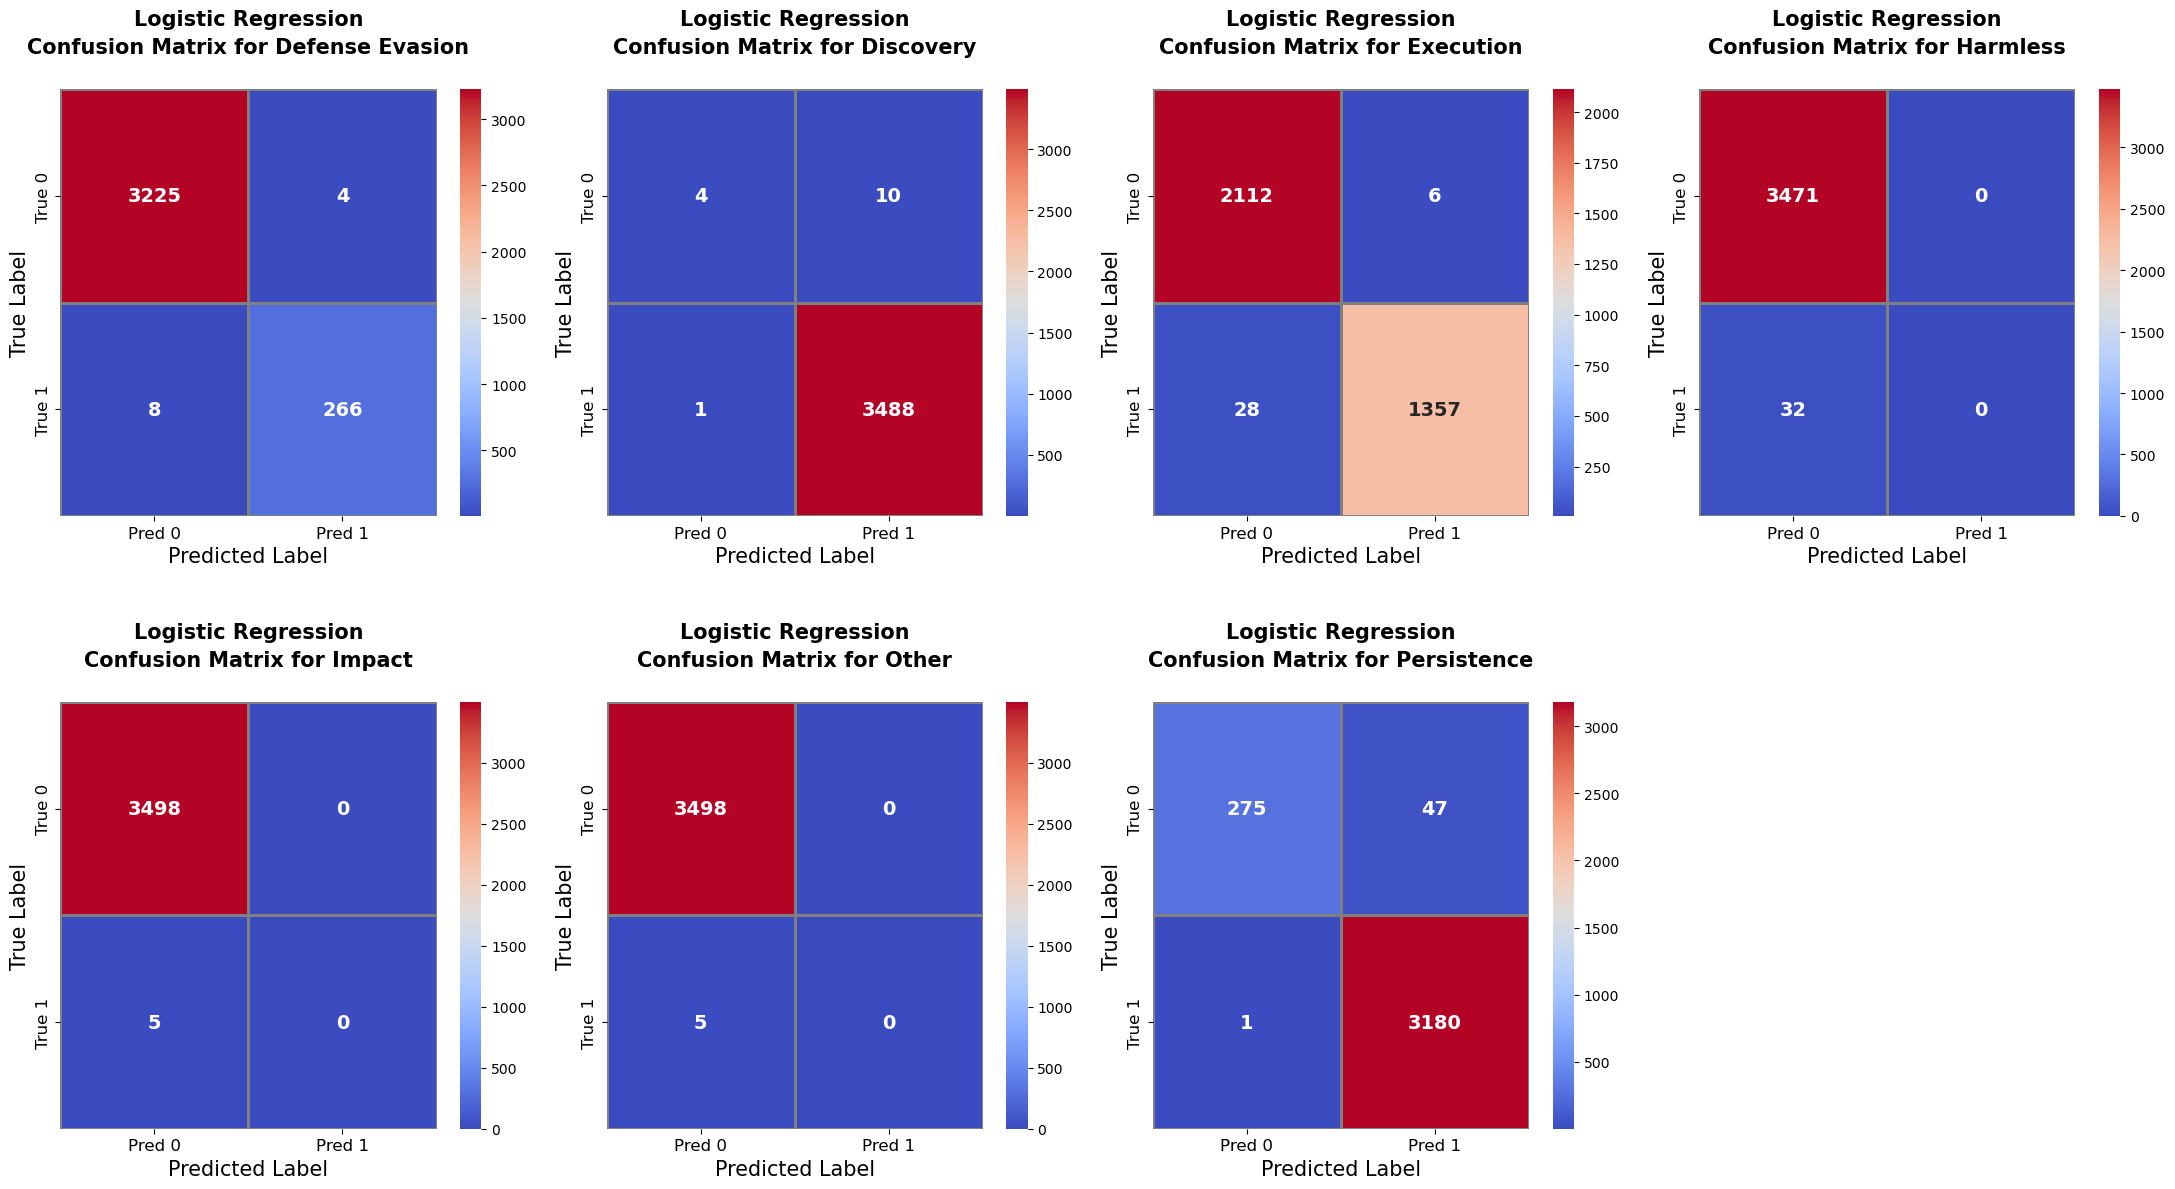


PERFORMANCE ON TRAIN SET: Logistic Regression

              Model   Set          Attack  Precision   Recall  F1-Score  Accuracy  Execution Time (s)
Logistic Regression Train Defense Evasion   0.992818 0.971493  0.981869  0.994616                 NaN
Logistic Regression Train       Discovery   0.979542 0.777716  0.851467  0.997430                 NaN
Logistic Regression Train       Execution   0.992152 0.989059  0.990545  0.990945                 NaN
Logistic Regression Train        Harmless   0.494493 0.500000  0.497231  0.988987                 NaN
Logistic Regression Train          Impact   0.499449 0.500000  0.499725  0.998899                 NaN
Logistic Regression Train           Other   0.498776 0.500000  0.499387  0.997553                 NaN
Logistic Regression Train     Persistence   0.990405 0.935791  0.961082  0.987274                 NaN

PERFORMANCE ON TEST SET: Logistic Regression

              Model  Set          Attack  Precision   Recall  F1-Score  Accuracy  Executi

In [17]:
# Train and evaluate Logistic Regression
model_name = "Logistic Regression"
model = models[model_name]

# Call to the function that returns the results and DataFrames for train and test
model_results[model_name], performance_comparison_lr_train, performance_comparison_lr_test = train_and_evaluate(
    model, model_name, X_train, X_test, y_train_binary, y_test_binary
)

# Print the results table for the train set
print(f"\n{'='*69}\nPERFORMANCE ON TRAIN SET: {model_name}\n{'='*69}\n")
print(performance_comparison_lr_train.to_string(index=False, max_colwidth=20))

# Print the results table for the test set
print(f"\n{'='*69}\nPERFORMANCE ON TEST SET: {model_name}\n{'='*69}\n")
print(performance_comparison_lr_test.to_string(index=False, max_colwidth=20))

# Add DataFrames to the performance list
performance_summaries.append(performance_comparison_lr_train)
performance_summaries.append(performance_comparison_lr_test)

### Random Forest

Here, the Random Forest model is trained on the training data, and its performance is evaluated similarly to Logistic Regression. The results, including the confusion matrix and classification report, are computed and displayed.

[No Overfitting] Random Forest - Label: Defense Evasion

[No Overfitting] Random Forest - Label: Discovery

[No Overfitting] Random Forest - Label: Execution

[No Overfitting] Random Forest - Label: Harmless

[No Overfitting] Random Forest - Label: Impact

[No Overfitting] Random Forest - Label: Other

[No Overfitting] Random Forest - Label: Persistence



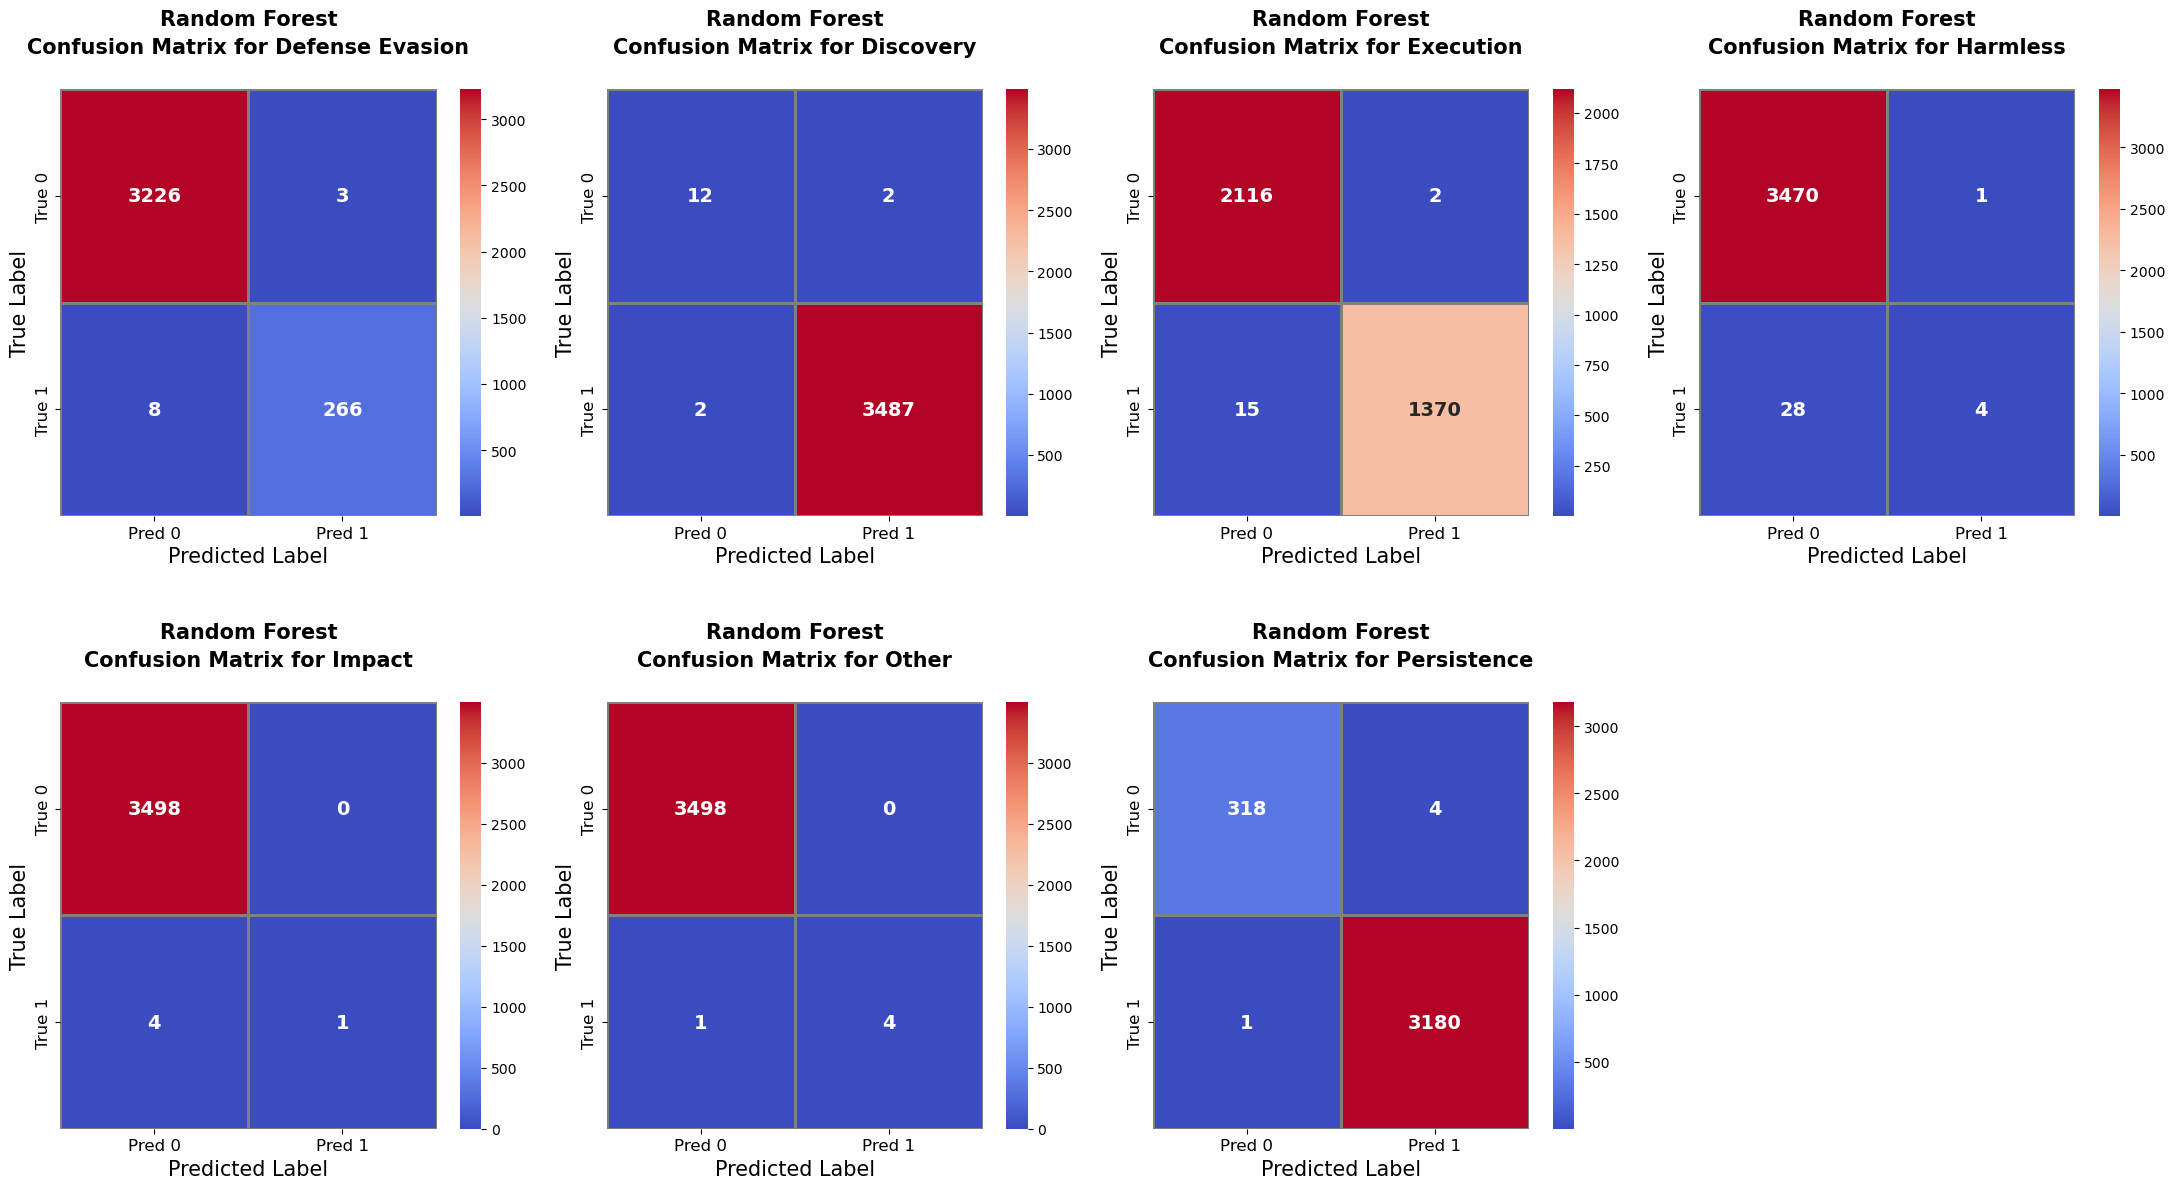


PERFORMANCE ON TRAIN SET: Random Forest

        Model   Set          Attack  Precision   Recall  F1-Score  Accuracy  Execution Time (s)
Random Forest Train Defense Evasion   0.995355 0.981982  0.988557  0.996574                 NaN
Random Forest Train       Discovery   0.989130 0.999938  0.994475  0.999878                 NaN
Random Forest Train       Execution   0.996444 0.994912  0.995663  0.995839                 NaN
Random Forest Train        Harmless   0.995889 0.627778  0.701476  0.991801                 NaN
Random Forest Train          Impact   0.999939 0.944444  0.970558  0.999878                 NaN
Random Forest Train           Other   1.000000 1.000000  1.000000  1.000000                 NaN
Random Forest Train     Persistence   0.999527 0.995524  0.997515  0.999143                 NaN

PERFORMANCE ON TEST SET: Random Forest

        Model  Set          Attack  Precision   Recall  F1-Score  Accuracy  Execution Time (s)
Random Forest Test Defense Evasion   0.993187 0.984937

In [18]:
# Train and evaluate Random Forest
model_name = "Random Forest"
model = models[model_name]

# Call to the function that returns the results and DataFrames for train and test
model_results[model_name], performance_comparison_rf_train, performance_comparison_rf_test = train_and_evaluate(
    model, model_name, X_train, X_test, y_train_binary, y_test_binary
)

# Print the results table for the train set
print(f"\n{'='*69}\nPERFORMANCE ON TRAIN SET: {model_name}\n{'='*69}\n")
print(performance_comparison_rf_train.to_string(index=False, max_colwidth=20))

# Print the results table for the test set
print(f"\n{'='*69}\nPERFORMANCE ON TEST SET: {model_name}\n{'='*69}\n")
print(performance_comparison_rf_test.to_string(index=False, max_colwidth=20))

# Add DataFrames to the performance list
performance_summaries.append(performance_comparison_rf_train)
performance_summaries.append(performance_comparison_rf_test)

### Support Vector Machine (SVM)

The SVM model is trained and evaluated in the same manner as the previous models. The confusion matrix and classification report are generated, and the results are stored for comparison.

[No Overfitting] SVM - Label: Defense Evasion

[No Overfitting] SVM - Label: Discovery

[No Overfitting] SVM - Label: Execution

[No Overfitting] SVM - Label: Harmless

[No Overfitting] SVM - Label: Impact

[No Overfitting] SVM - Label: Other

[No Overfitting] SVM - Label: Persistence



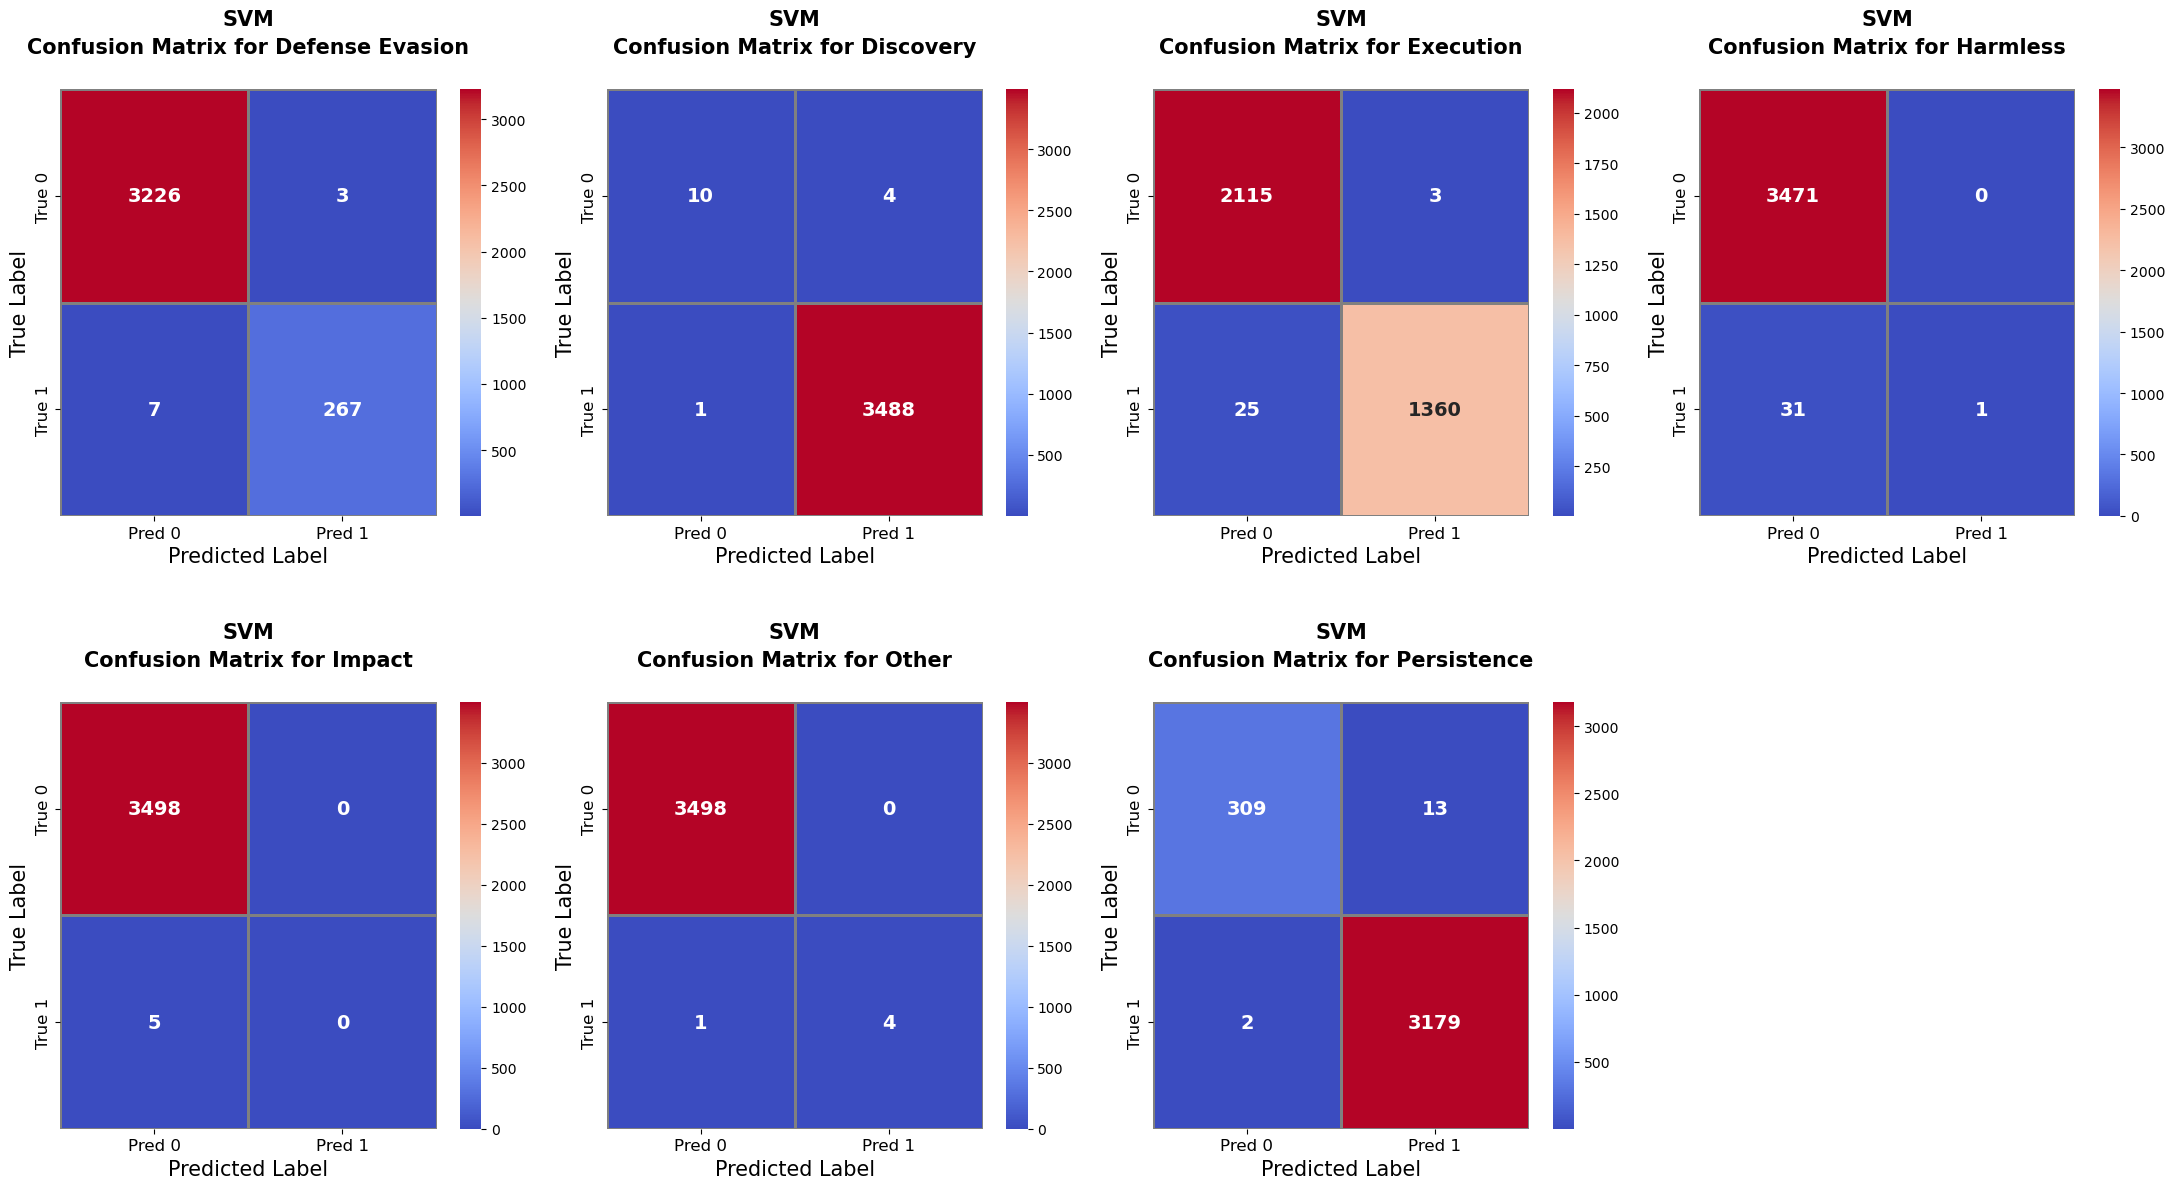


PERFORMANCE ON TRAIN SET: SVM

Model   Set          Attack  Precision   Recall  F1-Score  Accuracy  Execution Time (s)
  SVM Train Defense Evasion   0.993331 0.976671  0.984827  0.995472                 NaN
  SVM Train       Discovery   0.977088 0.966544  0.971756  0.999388                 NaN
  SVM Train       Execution   0.992552 0.989670  0.991058  0.991434                 NaN
  SVM Train        Harmless   0.994978 0.544444  0.579109  0.989966                 NaN
  SVM Train          Impact   0.499449 0.500000  0.499725  0.998899                 NaN
  SVM Train           Other   0.999694 0.875000  0.928418  0.999388                 NaN
  SVM Train     Persistence   0.996829 0.988288  0.992512  0.997430                 NaN

PERFORMANCE ON TEST SET: SVM

Model  Set          Attack  Precision   Recall  F1-Score  Accuracy  Execution Time (s)
  SVM Test Defense Evasion   0.993362 0.986762  0.990035  0.997145            0.118893
  SVM Test       Discovery   0.953973 0.857000  0.899642  0

In [19]:
# Train and evaluate SVM 
model_name = "SVM"
model = models[model_name]

# Call to the function that returns the results and DataFrames for train and test
model_results[model_name], performance_comparison_svm_train, performance_comparison_svm_test = train_and_evaluate(
    model, model_name, X_train, X_test, y_train_binary, y_test_binary
)

# Print the results table for the train set
print(f"\n{'='*69}\nPERFORMANCE ON TRAIN SET: {model_name}\n{'='*69}\n")
print(performance_comparison_svm_train.to_string(index=False, max_colwidth=20))

# Print the results table for the test set
print(f"\n{'='*69}\nPERFORMANCE ON TEST SET: {model_name}\n{'='*69}\n")
print(performance_comparison_svm_test.to_string(index=False, max_colwidth=20))

# Add DataFrames to the performance list
performance_summaries.append(performance_comparison_svm_train)
performance_summaries.append(performance_comparison_svm_test)

### Compare performances

In this step, we compare the performance of all models by calculating the average metrics for both the training and test sets.
We also check for signs of overfitting or underfitting by examining the difference between training and test accuracy.

Overfitting can be detected if the model performs significantly better on the training set compared to the test set.
Underfitting can be seen if the model performs poorly on both training and test sets.

The model with the best overall performance will be identified based on the metrics and consistency between training and test results.

In [20]:
def compare_train_test(performance_summaries):
    """
    Compare models by calculating and displaying mean metrics for train and test sets separately.
    Adds average execution time per model.
    """
    train_summaries = []
    test_summaries = []

    # Iterate over each model to collect results
    for idx, summary in enumerate(performance_summaries):
        model_name = summary["Model"].iloc[0]

        if idx % 2 == 0: 
            # Filter the results for the train set and calculate the average of the numeric columns
            train_metrics = summary[summary["Set"] == "Train"].select_dtypes(include='number').mean().to_dict()
            train_metrics["Model"] = model_name
            train_summaries.append(train_metrics)
        else: 
            # Filter the results for the test set and calculate the average of the numeric columns
            test_metrics = summary[summary["Set"] == "Test"].select_dtypes(include='number').mean().to_dict()
            test_metrics["Model"] = model_name
            test_summaries.append(test_metrics)


    # Create DataFrame for train and test tables
    train_df = pd.DataFrame(train_summaries)
    test_df = pd.DataFrame(test_summaries)

    # Calculate the average execution time (only on the test set)
    avg_test_time = test_df["Execution Time (s)"].mean()
    print(f"Average Test Time: {avg_test_time:.4f} seconds")

    # Sort columns by putting "Model" first
    cols_train = ["Model"] + [col for col in train_df.columns if col != "Model"]
    train_df = train_df[cols_train]

    cols_test = ["Model"] + [col for col in test_df.columns if col != "Model"]
    test_df = test_df[cols_test]

    # Print results
    print(f"\n{'='*69}\nTRAIN SET COMPARISON \n{'='*69}\n")
    print(train_df.to_string(index=False, max_colwidth=20))  # Train set

    print(f"\n{'='*69}\nTEST SET COMPARISON \n{'='*69}\n")
    print(test_df.to_string(index=False, max_colwidth=20))  # Test set

In [21]:
# Compare models
compare_train_test(performance_summaries)

Average Test Time: 0.5885 seconds

TRAIN SET COMPARISON 

              Model  Precision   Recall  F1-Score  Accuracy  Execution Time (s)
Logistic Regression   0.778234 0.739151  0.754472  0.993672                 NaN
      Random Forest   0.996612 0.934940  0.949749  0.997588                 NaN
                SVM   0.921989 0.834374  0.849629  0.995997                 NaN

TEST SET COMPARISON 

              Model  Precision   Recall  F1-Score  Accuracy  Execution Time (s)
Logistic Regression   0.766585 0.720405  0.734388  0.994005            1.290867
      Random Forest   0.972902 0.851903  0.874959  0.997105            0.351878
                SVM   0.918551 0.818450  0.834338  0.996126            0.122636


<center><b><font size=5>Hyperparameter Tuning<b><center>

In this step, we fine-tune the hyperparameters of the machine learning models using cross-validation to improve their performance. Hyperparameter tuning is crucial for optimizing the models and ensuring that they generalize well to unseen data.

**Steps:**

- Use GridSearchCV to perform hyperparameter optimization.
- Evaluate the performance of the tuned models.

### Choose hyperparameters

In this step, we focus on fine-tuning the hyperparameters of three models: Logistic Regression, Random Forest, and Support Vector Machine (SVM). We use GridSearchCV to explore a range of hyperparameter values for each model and identify the best combinations based on cross-validation.

In [43]:
param_grid_logreg = {
    'estimator__C': [0.1, 1, 10, 100],
    'estimator__solver': ['liblinear', 'saga', 'lbfgs'],
    'estimator__max_iter': [2000]
}

param_grid_rf = {
    'estimator__n_estimators': [50, 100, 150],
    'estimator__max_depth': [10, 50, 100],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],
    'estimator__random_state': [42]
}

param_grid_svm = {
    'estimator__C': [0.1, 1, 10, 100],
    'estimator__kernel': ['linear', 'rbf'],
    'estimator__gamma': ['scale', 'auto'],
    'estimator__random_state': [42]
}

### GridSearch

Here we perform hyperparameter tuning using GridSearchCV. After completing the grid search, we evaluate the best-performing models and compare their results to the baseline models to assess improvements in performance.

The heatmaps generated below show how different combinations of hyperparameters affect the weighted F1-score, which is used to evaluate the models' performance.

In [23]:
# Function to perform GridSearch
def hyperparameter_tuning_with_gridsearch(model_name, model, param_grid, X_train, y_train_binary):
    """
    Run GridSearchCV to tune model hyperparameters.
    Use OneVsRestClassifier for multilabel classification.
    """
    ovr_model = OneVsRestClassifier(model)
    scorer = make_scorer(f1_score, average='weighted', zero_division=1)
    
    grid_search = GridSearchCV(estimator=ovr_model, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, scoring=scorer)  
    
    print(f"\nTuning hyperparameters for {model_name}...\n")
    
    start_time = time.time()
    grid_search.fit(X_train, y_train_binary)
    end_time = time.time()
    
    elapsed_time = end_time - start_time
    print(f"\nTime to train the model: {elapsed_time:.2f} seconds")
    print(f"\nBest parameters for {model_name}: {grid_search.best_params_}")
    print(f"\nBest cross-validation score for {model_name}: {grid_search.best_score_:.4f}\n")
    
    return grid_search


Tuning hyperparameters for Logistic Regression...

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Time to train the model: 19.09 seconds

Best parameters for Logistic Regression: {'estimator__C': 100, 'estimator__max_iter': 2000, 'estimator__solver': 'liblinear'}

Best cross-validation score for Logistic Regression: 0.9925



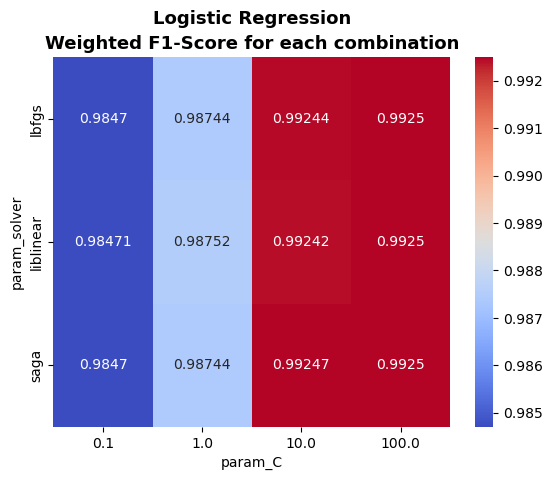

In [24]:
# Run GridSearch for Logistic Regression with OneVsRestClassifier
best_logreg_model = hyperparameter_tuning_with_gridsearch(
    "Logistic Regression", LogisticRegression(max_iter=2000, random_state=42), param_grid_logreg, X_train, y_train_binary
)

results_logreg = pd.DataFrame(best_logreg_model.cv_results_)

# Create a pivot table
scores_logreg = results_logreg.pivot(index='param_estimator__solver', 
                                     columns='param_estimator__C', 
                                     values='mean_test_score')

# View heatmap
sns.heatmap(scores_logreg, annot=True, cmap='coolwarm', fmt='.5g')
plt.xlabel('param_C')
plt.ylabel('param_solver')
plt.title('Logistic Regression\nWeighted F1-Score for each combination', fontsize=13, weight='bold', linespacing=1.5)

# Save the plot
current_fig = plt.gcf()
save_plot(current_fig, plot_directory, "weighted_f1_score_for_each_combination_of_parameters_logistic_regression", "png", global_overwrite)

# Show the plot
plt.show()


Tuning hyperparameters for Random Forest...

Fitting 5 folds for each of 81 candidates, totalling 405 fits

Time to train the model: 102.38 seconds

Best parameters for Random Forest: {'estimator__max_depth': 50, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 150, 'estimator__random_state': 42}

Best cross-validation score for Random Forest: 0.9935



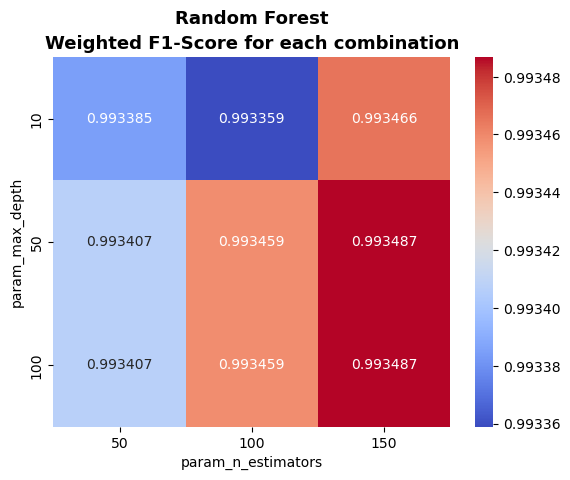

In [44]:
# Run GridSearch for Random Forest with OneVsRestClassifier
best_rf_model = hyperparameter_tuning_with_gridsearch(
    "Random Forest", RandomForestClassifier(random_state=42), param_grid_rf, X_train, y_train_binary
)

results_rf = pd.DataFrame(best_rf_model.cv_results_)

# Remove any duplicates
results_rf = results_rf.drop_duplicates(subset=['param_estimator__max_depth', 'param_estimator__n_estimators'])

# Create pivot table without duplicates
scores_rf = results_rf.pivot(index='param_estimator__max_depth', 
                             columns='param_estimator__n_estimators', 
                             values='mean_test_score')

# Heatmap
sns.heatmap(scores_rf, annot=True, cmap='coolwarm', fmt='.6g')
plt.xlabel('param_n_estimators')
plt.ylabel('param_max_depth')
plt.title('Random Forest\nWeighted F1-Score for each combination', fontsize=13, weight='bold', linespacing=1.5)

# Save the plot
current_fig = plt.gcf()
save_plot(current_fig, plot_directory, "weighted_f1_score_for_each_combination_of_parameters_random_forest", "png", global_overwrite)

# Show the plot
plt.show()


Tuning hyperparameters for SVM...

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Time to train the model: 9.59 seconds

Best parameters for SVM: {'estimator__C': 100, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf', 'estimator__random_state': 42}

Best cross-validation score for SVM: 0.9934



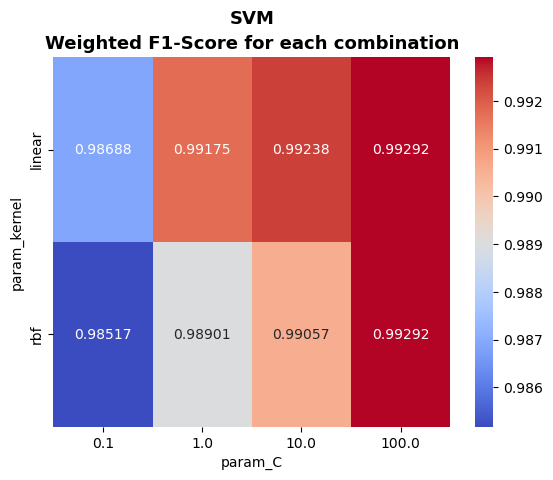

In [45]:
# Run GridSearch for SVM with OneVsRestClassifier
best_svm_model = hyperparameter_tuning_with_gridsearch(
    "SVM", SVC(random_state=42), param_grid_svm, X_train, y_train_binary
)

results_svm = pd.DataFrame(best_svm_model.cv_results_)

# Create pivot table with param_kernel and param_C as index and columns
scores_svm = results_svm.pivot_table(
    index='param_estimator__kernel', 
    columns='param_estimator__C', 
    values='mean_test_score', 
    aggfunc='mean'
)

# View la heatmap
sns.heatmap(scores_svm, annot=True, cmap='coolwarm', fmt='.5g')
plt.xlabel('param_C')
plt.ylabel('param_kernel')
plt.title('SVM\nWeighted F1-Score for each combination', fontsize=13, weight='bold', linespacing=1.5)

# Save the plot
current_fig = plt.gcf()
save_plot(current_fig, plot_directory, "weighted_f1_score_for_each_combination_of_parameters_svm", "png", global_overwrite)

# Show the plot
plt.show()

### Evaluate Tuned model

This step involves assessing the models based on various metrics such as precision, recall, and F1-score. The evaluation also includes visualizing the classification reports for both the training and testing sets.

By comparing these results with the baseline models, we can determine if the hyperparameter tuning has led to a performance improvement.

In [27]:
def evaluate_model(model, X_test, y_test, model_name, X_train, y_train, mlb):
    """
    Evaluates a model on a test set, handles warnings, and displays metrics.
    Save predictions in a dictionary.
    """
    
    print(f"\n{'='*69}\nEvaluation for {model_name}\n{'='*69}\n")
        
    # Convert y_test and y_train to NumPy arrays if they are DataFrames
    y_test = y_test.values if isinstance(y_test, pd.DataFrame) else y_test
    y_train = y_train.values if isinstance(y_train, pd.DataFrame) else y_train
    
    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Checking the size of y_test and y_pred
    if y_test.shape != y_pred_test.shape:
        raise ValueError("Mismatch between y_test and y_pred shapes.")
    
    # Multilabel predictions: apply threshold for each label
    y_pred_train = (y_pred_train > 0.5).astype(int)
    y_pred_test = (y_pred_test > 0.5).astype(int)
    
    
    # Saving predictions in the dictionary
    predictions_tuned = {
        model_name: {
            'train': y_pred_train,
            'test': y_pred_test
        }
    }
    
    # Classification Report
    for split, X, y, y_pred in zip(["Test", "Train"], [X_test, X_train], [y_test, y_train], [y_pred_test, y_pred_train]):
        report = classification_report(y, y_pred, target_names=mlb.classes_, output_dict=True, zero_division=0)
        
        # View the report in DataFrame format
        df_report = pd.DataFrame(report).transpose()
        
        # Heatmap for classification report
        plt.figure(figsize=(5, 3))
        sns.heatmap(df_report.loc["Defense Evasion" : "samples avg"], cmap='Blues', annot=True, vmin=0, vmax=1, fmt='.3f')
        plt.xlabel('Intents')
        plt.ylabel('Evaluation technique')
        plt.title(f'{model_name}\nClassification Report for {split} Set', fontsize=12, weight='bold', linespacing=1.5)
        
        # Save the plot
        current_fig = plt.gcf()
        save_plot(current_fig, plot_directory, f"{model_name}_classification_report_for_{split}_set", "png", global_overwrite)

        # Show the plot
        plt.show()
        
        # Macro and Weighted Metrics
        precision_macro = report['macro avg']['precision']
        recall_macro = report['macro avg']['recall']
        f1_macro = report['macro avg']['f1-score']
        
        precision_weighted = report['weighted avg']['precision']
        recall_weighted = report['weighted avg']['recall']
        f1_weighted = report['weighted avg']['f1-score']
        
        print(f"\n{split} Precision (macro): {precision_macro:.4f}")
        print(f"{split} Recall (macro): {recall_macro:.4f}")
        print(f"{split} F1 Score (macro): {f1_macro:.4f}")
        
        print(f"\n{split} Precision (weighted): {precision_weighted:.4f}")
        print(f"{split} Recall (weighted): {recall_weighted:.4f}")
        print(f"{split} F1 Score (weighted): {f1_weighted:.4f}\n")
    
    # Return the dictionary with predictions
    return predictions_tuned


Evaluation for Logistic Regression

Overwriting file: '../results/figures/plots/section2/Logistic Regression_classification_report_for_Test_set.png'
Plot saved successfully at: '../results/figures/plots/section2/Logistic Regression_classification_report_for_Test_set.png'


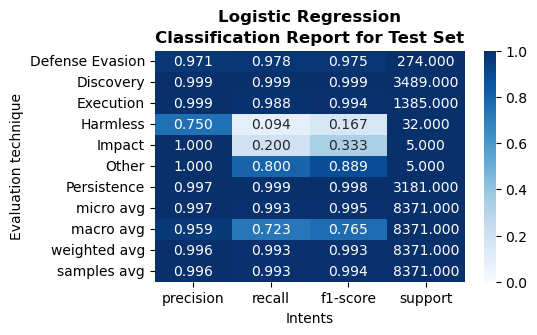


Test Precision (macro): 0.9594
Test Recall (macro): 0.7227
Test F1 Score (macro): 0.7649

Test Precision (weighted): 0.9963
Test Recall (weighted): 0.9928
Test F1 Score (weighted): 0.9934

Overwriting file: '../results/figures/plots/section2/Logistic Regression_classification_report_for_Train_set.png'
Plot saved successfully at: '../results/figures/plots/section2/Logistic Regression_classification_report_for_Train_set.png'


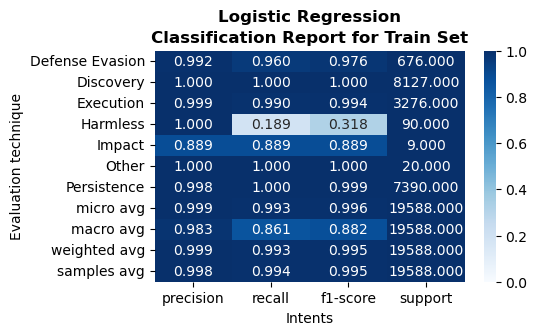


Train Precision (macro): 0.9826
Train Recall (macro): 0.8611
Train F1 Score (macro): 0.8823

Train Precision (weighted): 0.9988
Train Recall (weighted): 0.9930
Train F1 Score (weighted): 0.9946



In [28]:
# Run model evaluation for Logistic Regression
tuned_pred_logreg = evaluate_model(
    best_logreg_model,
    X_test,
    y_test_binary,
    "Logistic Regression",
    X_train,
    y_train_binary,
    mlb
)


Evaluation for Random Forest

Overwriting file: '../results/figures/plots/section2/Random Forest_classification_report_for_Test_set.png'
Plot saved successfully at: '../results/figures/plots/section2/Random Forest_classification_report_for_Test_set.png'


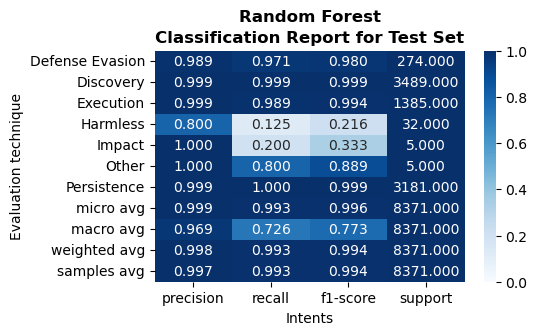


Test Precision (macro): 0.9694
Test Recall (macro): 0.7263
Test F1 Score (macro): 0.7730

Test Precision (weighted): 0.9979
Test Recall (weighted): 0.9930
Test F1 Score (weighted): 0.9943

Overwriting file: '../results/figures/plots/section2/Random Forest_classification_report_for_Train_set.png'
Plot saved successfully at: '../results/figures/plots/section2/Random Forest_classification_report_for_Train_set.png'


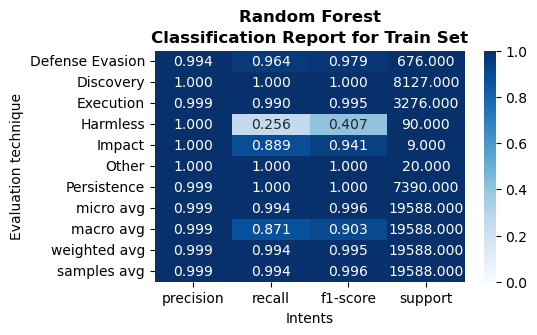


Train Precision (macro): 0.9989
Train Recall (macro): 0.8713
Train F1 Score (macro): 0.9031

Train Precision (weighted): 0.9993
Train Recall (weighted): 0.9936
Train F1 Score (weighted): 0.9954



In [29]:
# Run model evaluation for Random Forest
tuned_pred_rf = evaluate_model(
    best_rf_model,
    X_test,
    y_test_binary,
    "Random Forest",
    X_train,
    y_train_binary,
    mlb
)


Evaluation for SVM

Overwriting file: '../results/figures/plots/section2/SVM_classification_report_for_Test_set.png'
Plot saved successfully at: '../results/figures/plots/section2/SVM_classification_report_for_Test_set.png'


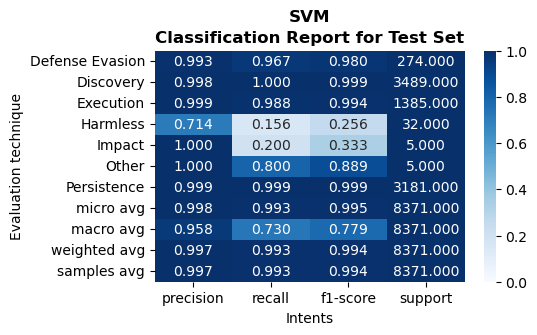


Test Precision (macro): 0.9575
Test Recall (macro): 0.7301
Test F1 Score (macro): 0.7786

Test Precision (weighted): 0.9972
Test Recall (weighted): 0.9928
Test F1 Score (weighted): 0.9942

Overwriting file: '../results/figures/plots/section2/SVM_classification_report_for_Train_set.png'
Plot saved successfully at: '../results/figures/plots/section2/SVM_classification_report_for_Train_set.png'


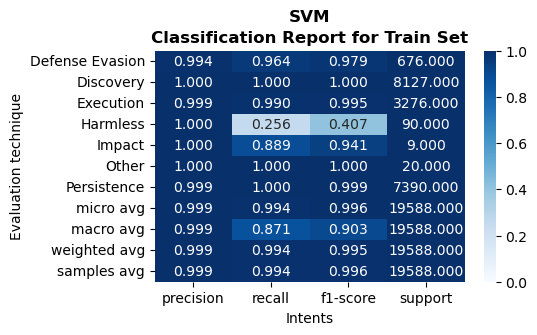


Train Precision (macro): 0.9989
Train Recall (macro): 0.8713
Train F1 Score (macro): 0.9031

Train Precision (weighted): 0.9993
Train Recall (weighted): 0.9936
Train F1 Score (weighted): 0.9954



In [30]:
# Run model evaluation for SVM
tuned_pred_svm = evaluate_model(
    best_svm_model,
    X_test,
    y_test_binary,
    "SVM",
    X_train,
    y_train_binary,
    mlb
)

<center><b><font size=5>Comparing models<b><center>

In this step, we compare the performance of the baseline models and the optimized models. The main metric used for comparison is the F1 score, which provides a balance between precision and recall. Additionally, we calculate and display other performance metrics, such as precision and recall, for both the baseline and the optimized models.

This comparison helps us assess the effectiveness of model tuning and understand how much the optimization process has contributed to improving the model's performance on unseen data.

In [37]:
# Function to evaluate base and optimized models
def compare_models(base_model, tuned_pred, X_test, y_test, model_name, mlb):
    """
    Compare the performance of a baseline model and an optimized model.
    """
    print(f"\n{'='*69}\n{model_name} Comparison\n{'='*69}\n")

    # Convert y_test to NumPy array if needed
    if isinstance(y_test, pd.DataFrame):
        y_test = y_test.to_numpy()
    if len(y_test.shape) == 1:
        y_test = label_binarize(y_test, classes=range(len(mlb.classes_)))  # One-hot encoding
    
    y_test_labels = y_test.argmax(axis=1)  # Convert from one-hot encoding to labels
    
    # Predictions for the base model
    base_pred = base_model.predict(X_test)
    if len(base_pred.shape) > 1:  # If the predictions are in one-hot format
        base_pred = base_pred.argmax(axis=1)
    
    # F1 score calculation for the base model
    base_f1 = f1_score(y_test_labels, base_pred, average='weighted', zero_division=0)
    
    # Predictions for the optimized model (already saved)
    if len(tuned_pred.shape) > 1:  # If the predictions are in one-hot format
        tuned_pred = tuned_pred.argmax(axis=1)
    
    # Calculate F1 score for the optimized model
    tuned_f1 = f1_score(y_test_labels, tuned_pred, average='weighted', zero_division=0)
    
    print(f"Base Model F1 Score: {base_f1:.4f}")
    print(f"Tuned Model F1 Score: {tuned_f1:.4f}")
    
    # Calculating the percentage improvement
    improvement_percentage = ((tuned_f1 - base_f1) / base_f1) * 100 if base_f1 != 0 else float('inf')
    print(f"Improvement in F1 Score: {improvement_percentage:.2f}%\n")
    
    # View metrics for both models
    metrics = ["Precision", "Recall", "F1 Score"]
    base_metrics = [
        precision_score(y_test_labels, base_pred, average='weighted', zero_division=0),
        recall_score(y_test_labels, base_pred, average='weighted', zero_division=0),
        base_f1
    ]
    tuned_metrics = [
        precision_score(y_test_labels, tuned_pred, average='weighted', zero_division=0),
        recall_score(y_test_labels, tuned_pred, average='weighted', zero_division=0),
        tuned_f1
    ]
    
    # Plot comparison between the two models
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.figure(figsize=(8, 6))
    plt.bar(x - width/2, base_metrics, width, label="Base Model", color='lightblue')
    plt.bar(x + width/2, tuned_metrics, width, label="Tuned Model", color='orange')
    plt.xticks(x, metrics)
    plt.title(f"{model_name} - Metrics Comparison", fontsize=15, weight='bold', linespacing=1.5)
    plt.ylabel("Score")
    plt.legend()
    
    # Save the plot
    current_fig = plt.gcf()
    save_plot(current_fig, plot_directory, f"{model_name}_Metric_comparison", "png", global_overwrite)
    
    plt.show()
    
    # === ROC Curve ===
    print(f"\n{'='*69}\nGenerating ROC Curves\n{'='*69}\n")
    
    from sklearn.metrics import roc_curve, auc

    # Determines the number of rows and columns for the chart layout
    n_classes = len(mlb.classes_)
    n_cols = 4  
    n_rows = (n_classes // n_cols) + (n_classes % n_cols > 0)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()  # Makes the axis array an array for easy indexing
    
    for i, class_name in enumerate(mlb.classes_):
        ax = axes[i]
        
        # Check if the base model supports `decision_function` or `predict_proba`
        if hasattr(base_model, "decision_function"):
            base_scores = base_model.decision_function(X_test)
        elif hasattr(base_model, "predict_proba"):
            base_scores = base_model.predict_proba(X_test)[:, 1] if base_model.predict_proba(X_test).ndim == 2 else base_model.predict_proba(X_test)
        else:
            print(f"Skipping ROC curve for {class_name}: Model does not support probability scores.")
            continue
                
        # Binary case management
        if base_scores.ndim == 1:
            base_fpr, base_tpr, _ = roc_curve(y_test[:, i], base_scores)
            base_auc = auc(base_fpr, base_tpr)
        else:
            base_fpr, base_tpr, _ = roc_curve(y_test[:, i], base_scores[:, i])
            base_auc = auc(base_fpr, base_tpr)
        
        tuned_scores = tuned_pred if tuned_pred.ndim == 1 else tuned_pred[:, i]
        tuned_fpr, tuned_tpr, _ = roc_curve(y_test[:, i], tuned_scores)
        tuned_auc = auc(tuned_fpr, tuned_tpr)
        
        # Draw ROC curves for this class
        ax.plot(base_fpr, base_tpr, label=f"Base Model (AUC = {base_auc:.2f})", color='blue')
        ax.plot(tuned_fpr, tuned_tpr, label=f"Tuned Model (AUC = {tuned_auc:.2f})", color='orange')
        ax.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title(f"ROC Curve for Class: {class_name}", fontsize=12, weight='bold', linespacing=1.5)
        ax.legend(loc="lower right")

    # Remove unused axes if there are any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Save the plot
    current_fig = plt.gcf()
    save_plot(current_fig, plot_directory, f"{model_name}_ROC", "png", global_overwrite)
        
    plt.tight_layout()
    plt.show()
    
     # === Error Analysis ===
    print(f"\n{'='*69}\nError Analysis\n{'='*69}\n")
    error_indices_base = np.where(base_pred != y_test_labels)[0]
    error_indices_tuned = np.where(tuned_pred != y_test_labels)[0]
    
    print(f"\nErrors made by the base model (first 7):")
    for i in error_indices_base[:7]:
        print(f"True: {y_test_labels[i]}, Predicted: {base_pred[i]}")

    print(f"\nErrors made by the tuned model (first 7):")
    for i in error_indices_tuned[:7]:
        print(f"True: {y_test_labels[i]}, Predicted: {tuned_pred[i]}")
    
    from sklearn.calibration import CalibratedClassifierCV
    from sklearn.multioutput import MultiOutputClassifier

    # === Prediction Probability Distribution ===
    print(f"\n{'='*69}\nPrediction Probability Distribution\n{'='*69}\n")

    # Calibrate the base model for each label
    multi_output_model = MultiOutputClassifier(base_model)
    base_model_calibrated = MultiOutputClassifier(CalibratedClassifierCV(base_model, method='sigmoid'))

    # Train models
    multi_output_model.fit(X_train, y_train_binary)
    base_model_calibrated.fit(X_train, y_train_binary)

    # Get the predicted odds
    base_probabilities = base_model_calibrated.predict_proba(X_test)

    # Flatten the probabilities for each class
    base_probabilities_flat = np.concatenate([prob.flatten() for prob in base_probabilities])

    # Plot of probability distributions
    plt.figure(figsize=(8, 6))
    sns.histplot(base_probabilities_flat, kde=True, color='blue', label='Base Model')
    sns.histplot(tuned_pred.flatten(), kde=True, color='orange', label='Tuned Model')
    plt.title(f"{model_name} - Prediction Probability Distribution", fontsize=15, weight='bold', linespacing=1.5)
    plt.xlabel("Probability")
    plt.ylabel("Frequency")
    plt.legend()
    
    # Save the plot
    current_fig = plt.gcf()
    save_plot(current_fig, plot_directory, f"{model_name}_Probability_distribution", "png", global_overwrite)
    
    plt.show()



Logistic Regression Comparison

Base Model F1 Score: 0.9876
Tuned Model F1 Score: 0.9944
Improvement in F1 Score: 0.69%

Overwriting file: '../results/figures/plots/section2/Logistic Regression_Metric_comparison.png'
Plot saved successfully at: '../results/figures/plots/section2/Logistic Regression_Metric_comparison.png'


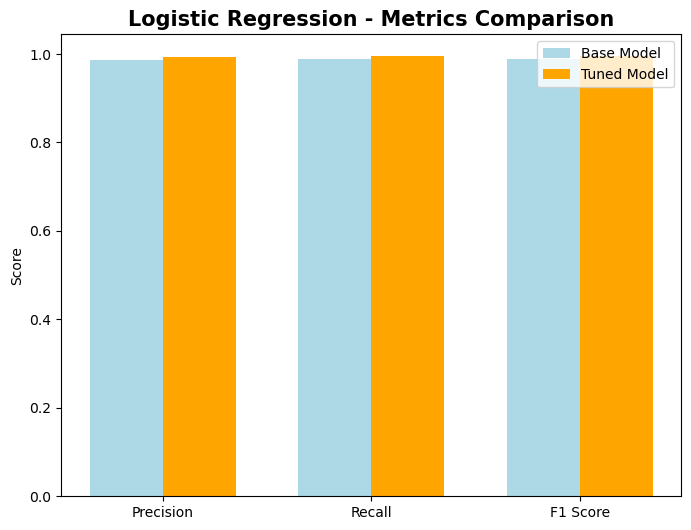


Generating ROC Curves

Plot saved successfully at: '../results/figures/plots/section2/Logistic Regression_ROC.png'


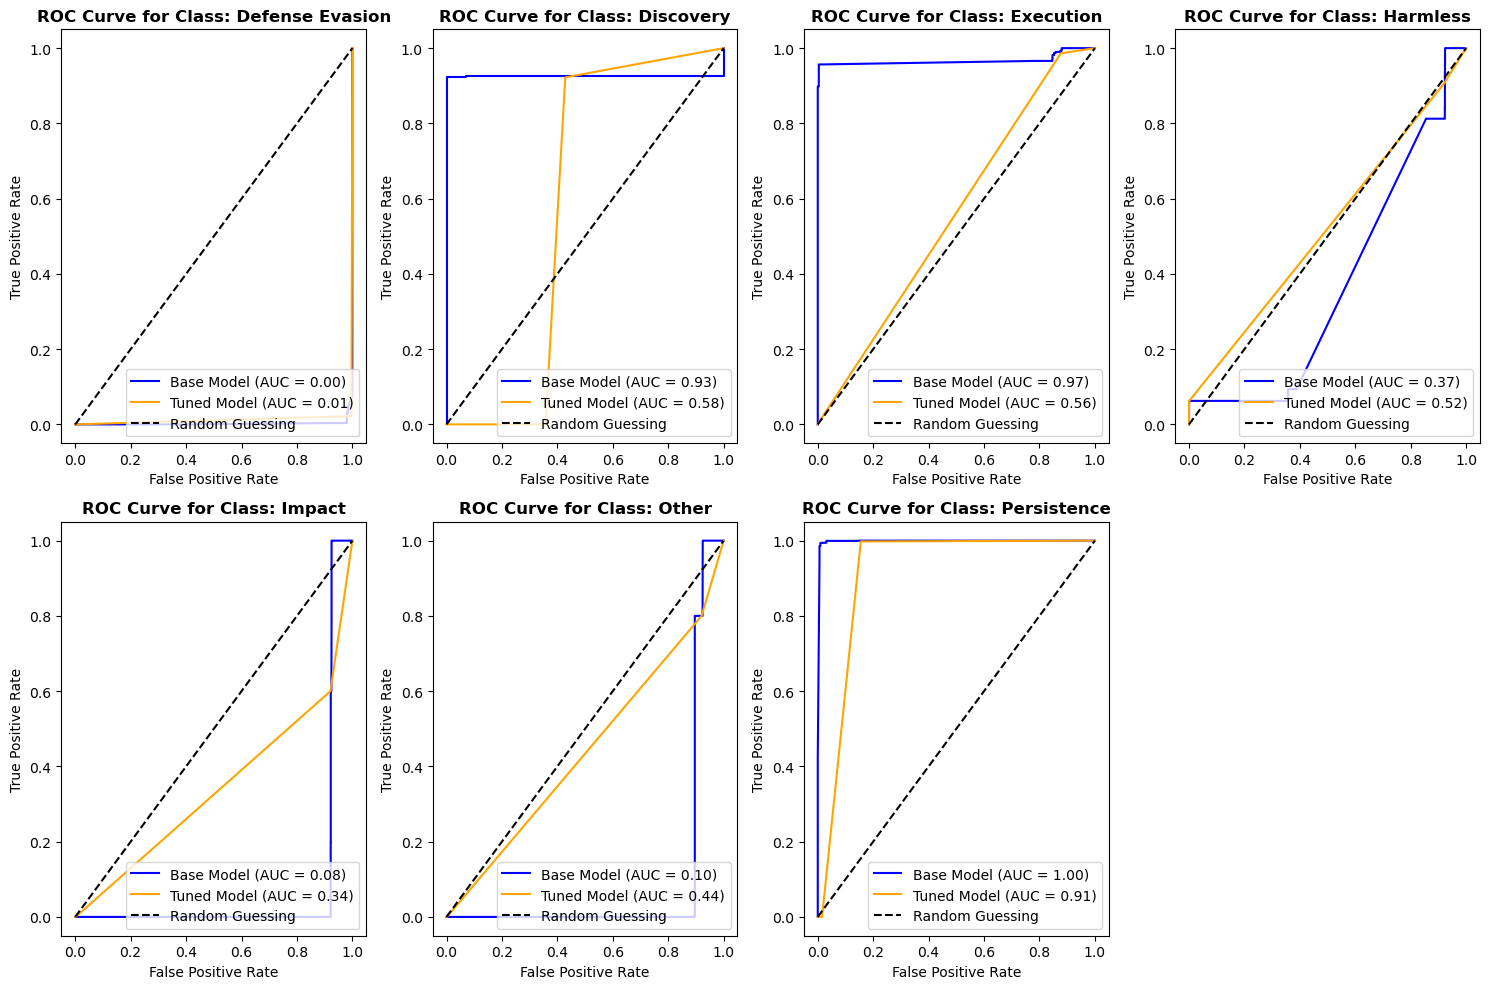


Error Analysis


Errors made by the base model (first 7):
True: 0, Predicted: 1
True: 2, Predicted: 0
True: 2, Predicted: 0
True: 0, Predicted: 1
True: 0, Predicted: 1
True: 0, Predicted: 1
True: 0, Predicted: 1

Errors made by the tuned model (first 7):
True: 2, Predicted: 0
True: 0, Predicted: 1
True: 0, Predicted: 1
True: 0, Predicted: 1
True: 0, Predicted: 1
True: 1, Predicted: 0
True: 1, Predicted: 0

Prediction Probability Distribution

Plot saved successfully at: '../results/figures/plots/section2/Logistic Regression_Probability_distribution.png'


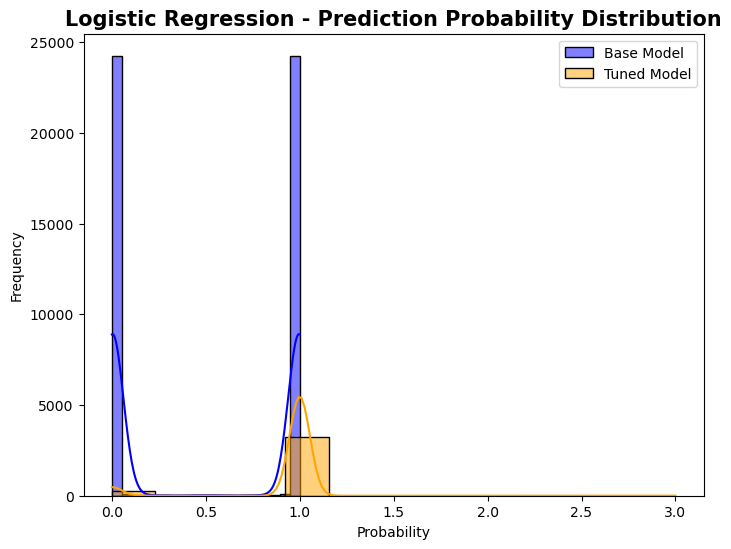

In [38]:
tuned_logreg = tuned_pred_logreg['Logistic Regression']['test']

compare_models(models["Logistic Regression"], tuned_logreg, X_test, y_test_binary, "Logistic Regression", mlb)


Random Forest Comparison

Base Model F1 Score: 0.9827
Tuned Model F1 Score: 0.9944
Improvement in F1 Score: 1.19%

Overwriting file: '../results/figures/plots/section2/Random Forest_Metric_comparison.png'
Plot saved successfully at: '../results/figures/plots/section2/Random Forest_Metric_comparison.png'


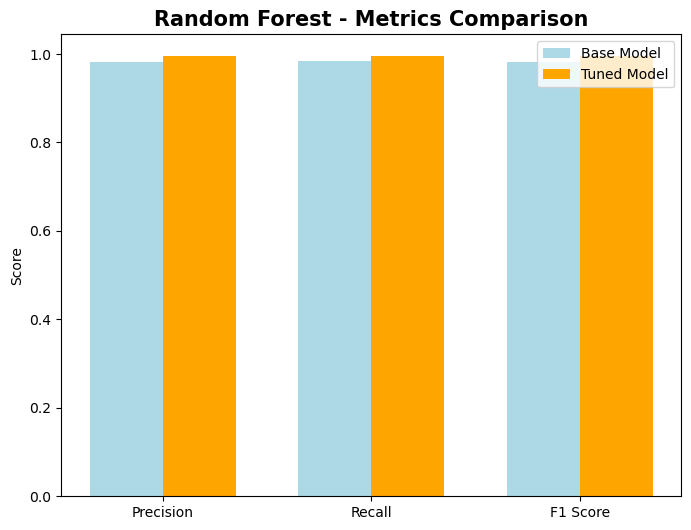


Generating ROC Curves

Plot saved successfully at: '../results/figures/plots/section2/Random Forest_ROC.png'


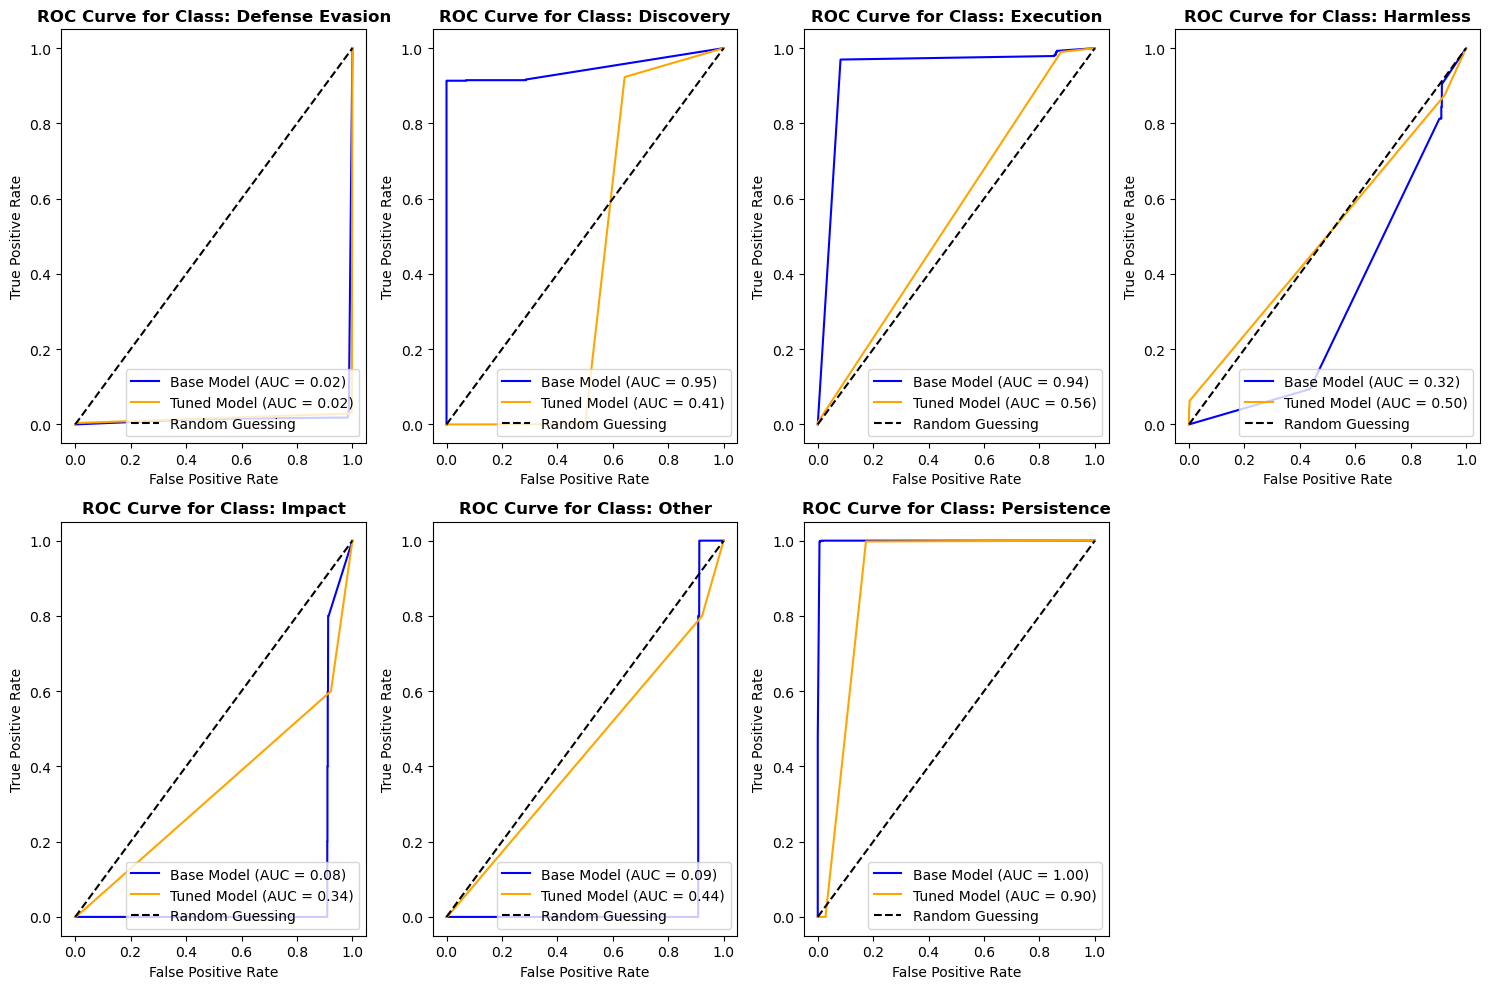


Error Analysis


Errors made by the base model (first 7):
True: 1, Predicted: 0
True: 0, Predicted: 1
True: 1, Predicted: 0
True: 1, Predicted: 0
True: 2, Predicted: 0
True: 1, Predicted: 0
True: 1, Predicted: 0

Errors made by the tuned model (first 7):
True: 0, Predicted: 1
True: 3, Predicted: 0
True: 0, Predicted: 1
True: 0, Predicted: 1
True: 0, Predicted: 1
True: 0, Predicted: 1
True: 1, Predicted: 0

Prediction Probability Distribution

Plot saved successfully at: '../results/figures/plots/section2/Random Forest_Probability_distribution.png'


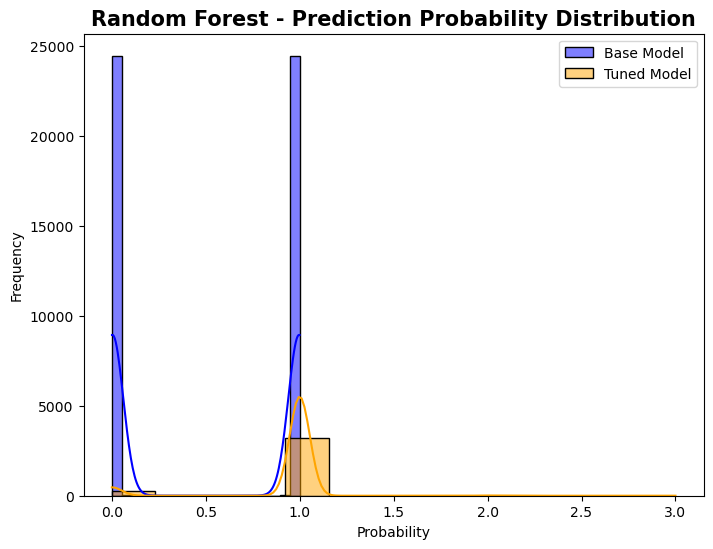

In [39]:
tuned_rf = tuned_pred_rf['Random Forest']['test']

compare_models(models["Random Forest"], tuned_rf, X_test, y_test_binary, "Random Forest", mlb)


SVM Comparison

Base Model F1 Score: 0.9810
Tuned Model F1 Score: 0.9946
Improvement in F1 Score: 1.39%

Overwriting file: '../results/figures/plots/section2/SVM_Metric_comparison.png'
Plot saved successfully at: '../results/figures/plots/section2/SVM_Metric_comparison.png'


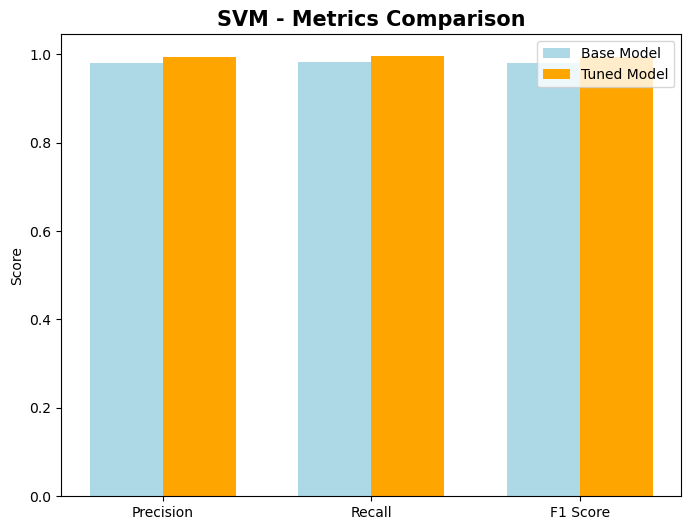


Generating ROC Curves

Plot saved successfully at: '../results/figures/plots/section2/SVM_ROC.png'


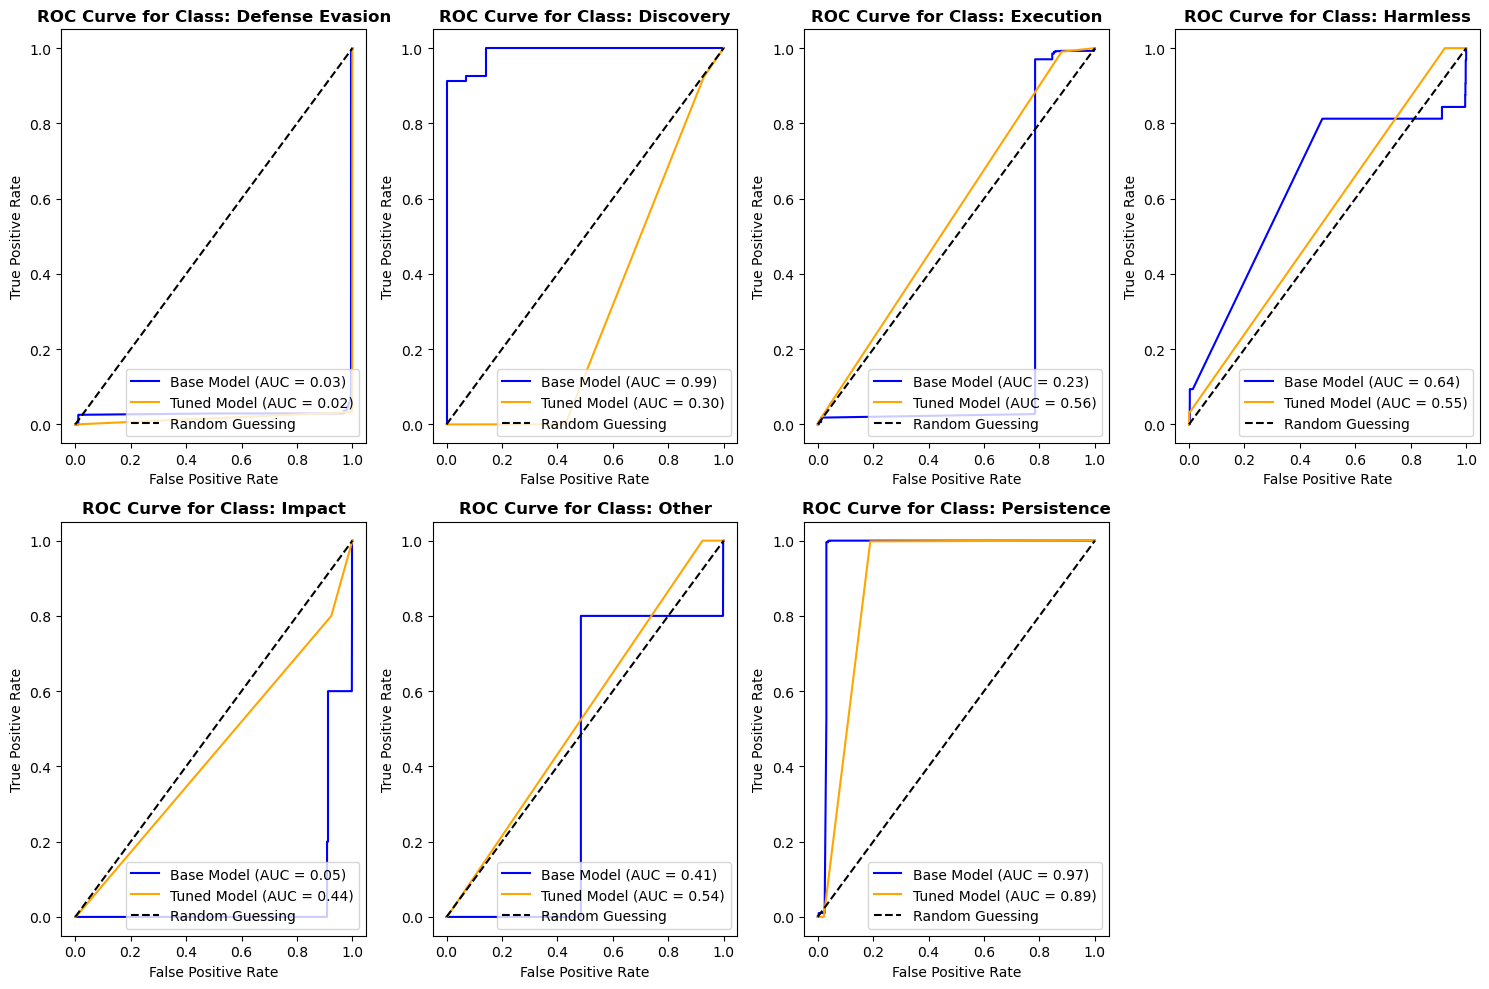


Error Analysis


Errors made by the base model (first 7):
True: 0, Predicted: 1
True: 1, Predicted: 0
True: 1, Predicted: 0
True: 2, Predicted: 0
True: 1, Predicted: 0
True: 1, Predicted: 0
True: 2, Predicted: 0

Errors made by the tuned model (first 7):
True: 0, Predicted: 1
True: 3, Predicted: 1
True: 0, Predicted: 1
True: 0, Predicted: 1
True: 0, Predicted: 1
True: 0, Predicted: 1
True: 0, Predicted: 1

Prediction Probability Distribution

Plot saved successfully at: '../results/figures/plots/section2/SVM_Probability_distribution.png'


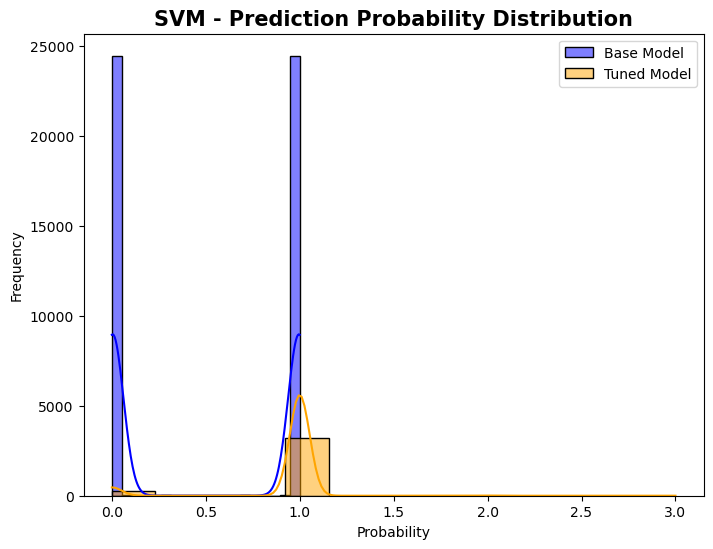

In [40]:
tuned_svm = tuned_pred_svm['SVM']['test']

compare_models(models["SVM"], tuned_svm, X_test, y_test_binary, "SVM", mlb)